In [1]:
import json
import pandas as pd
import numpy as np

Sensor_readings = pd.read_json('data/W512_readings.json')
Aircon_Data = pd.read_json('data/W512_aircon_status.json')
Weather_readings = pd.read_json('data/Weather_data.json')

def convert_AirconData(data):
    records = []
    
    for index, row in data.iterrows():
        # Parse FC_FullStatus_Readings if it's a string representation of a dictionary
        if isinstance(row['FC_FullStatus_Readings'], str):
            fc_readings = ast.literal_eval(row['FC_FullStatus_Readings'])
        else:
            fc_readings = row['FC_FullStatus_Readings']


        try:
            combined_datetime = pd.to_datetime(f"{row['date']} {row['time']}")
            formatted_datetime = pd.to_datetime(combined_datetime.strftime("%Y-%m-%d %H:%M:%S"))

        except Exception as e:
            print(f"Error combining datetime for row {index}: {e}")
            combined_datetime = None
            formatted_datetime = None

        
        # Create a record with base information
        record = {
            'Datetime': formatted_datetime
        }
        
        # Add each FC Unit's details as separate columns
        for unit, unit_data in fc_readings.items():
            record[f'{unit}_Status'] = unit_data['Status']
            record[f'{unit}_Fan_Status'] = unit_data['Fan_Status']
            record[f'{unit}_Set_Point'] = unit_data['Set_Point']
            record[f'{unit}_Operation_Mode'] = unit_data['Operation_Mode']
        
        records.append(record)
    
    # Create DataFrame
    df = pd.DataFrame(records)
    return df


def convert_sensorReadings(data):
    records = []
    
    # List of keys to exclude from Lorawan_Readings
    include_keys_1 = ["24E124725E285123", "24E124725E331695","24E124725E331744",
                      "24E124725E332483","24E124725E290348","24E124725E331733","24E124725E286745"]#"24E124136D316361" is suppiosed to be outdoor but it is not outdoor yet
    include_keys_2 = ["Sensor_1","Sensor_3","Sensor_6"]
    
    for index, row in data.iterrows():
        # Parse Energy_Readings if it's a string representation of a dictionary
        if isinstance(row['Energy_Readings'], str):
            Energy_readings = ast.literal_eval(row['Energy_Readings'])
        else:
            Energy_readings = row['Energy_Readings']
            
        # Parse Lorawan_Readings if it's a string representation of a dictionary
        if isinstance(row['Lorawan_Readings'], str):
            Lorawan_Readings = ast.literal_eval(row['Lorawan_Readings'])
        else:
            Lorawan_Readings = row['Lorawan_Readings']

        try:
            # Combine the date and time columns to create a datetime object
            combined_datetime = pd.to_datetime(f"{row['date']} {row['time']}")
            formatted_datetime = pd.to_datetime(combined_datetime.strftime("%Y-%m-%d %H:%M:%S"))
        except Exception as e:
            print(f"Error combining datetime for row {index}: {e}")
            formatted_datetime = None

        # Create a record with base information
        record = {
            'Datetime': formatted_datetime
        }
        
        # Add each Energy sensor's details as separate columns
        for unit, unit_data in Energy_readings.items():
            if unit not in include_keys_2:
                continue
                
            record[f'{unit}_Current'] = unit_data['Current']
            record[f'{unit}_Energy'] = unit_data['Energy']
            record[f'{unit}_Power'] = unit_data['Power']
        
        # Add each Lorawan device's details as separate columns
        for unit, unit_data in Lorawan_Readings.items():
            if unit not in include_keys_1:
                continue
            record[f'{unit}_Humidity'] = unit_data.get('humidity', None)
            record[f'{unit}_Temperature'] = unit_data.get('temperature', None)

            co2_value = unit_data.get('co2', None)
            if co2_value is not None:
                record[f'{unit}_CO2'] = co2_value

        # Append the record to the list of records
        records.append(record)
    df=pd.DataFrame(records)
    return df


def convert_weatherData(data):
    records = []
    for index, row in data.iterrows():
        # Parse Energy_Readings if it's a string representation of a dictionary
        if isinstance(row['result'], str):
            weather_results = ast.literal_eval(row['result'])
        else:
            weather_results = row['result']
            
        try:
            combined_datetime = pd.to_datetime(f"{row['date']} {row['time']}")
            formatted_datetime = pd.to_datetime(combined_datetime.strftime("%Y-%m-%d %H:%M:%S"))
        except Exception as e:
            print(f"Error combining datetime for row {index}: {e}")
            formatted_datetime = None

        record = {
            'Datetime': formatted_datetime
        }  

        record['weather_status'] = weather_results['weather_status']
        record['weather_temp'] = weather_results['weather_temp']
        record['weather_humid'] = weather_results['weather_humidity']
            
        records.append(record)
    df=pd.DataFrame(records)
    return df



Aircon_data_df = convert_AirconData(Aircon_Data)
Aircon_data_df = Aircon_data_df[3194:]
Sensor_readings_df = convert_sensorReadings(Sensor_readings)
Sensor_readings_df = Sensor_readings_df.interpolate(method='linear')
weather_readings_df = convert_weatherData(Weather_readings)

# Merge Aircon data with Sensor readings using merge_asof
merged_df = pd.merge_asof(Aircon_data_df, Sensor_readings_df, on='Datetime', direction='nearest')

# Now, merge the Weather readings with the previous result using merge_asof
merged_df = pd.merge_asof(merged_df, weather_readings_df, on='Datetime', direction='nearest')


merged_df['total_energy'] = (
    merged_df['Sensor_1_Energy'] +
    merged_df['Sensor_3_Energy'] +
    merged_df['Sensor_6_Energy']
)

merged_df['total_power'] = (
    merged_df['Sensor_1_Power'] +
    merged_df['Sensor_3_Power'] +
    merged_df['Sensor_6_Power']
)

merged_df['total_current'] = (
    merged_df['Sensor_1_Current'] +
    merged_df['Sensor_3_Current'] +
    merged_df['Sensor_6_Current']
)

temperature_col = [
    col for col in merged_df.columns 
    if "24e124" in col.lower() and "temperature" in col.lower()
]
humidity_col = [
    col for col in merged_df.columns 
    if "24e124" in col.lower() and "humidity" in col.lower()
]
co2_col = [
    col for col in merged_df.columns 
    if "24e124" in col.lower() and "co2" in col.lower()
]

merged_df['avg_temperature'] = merged_df[temperature_col].mean(axis=1)
merged_df['avg_humidity'] = merged_df[humidity_col].mean(axis=1)
merged_df['avg_co2'] = merged_df[co2_col].mean(axis=1)

merged_df['hour'] = pd.to_datetime(merged_df['Datetime']).dt.hour
merged_df['Day_of_week'] = pd.to_datetime(merged_df['Datetime']).dt.dayofweek

dropped_col = [
    col for col in merged_df.columns
    if "24e124" in col.lower()
]
dropped_col_sensor = [
    col for col in merged_df.columns
    if "sensor" in col.lower()
]

columns_to_drop = dropped_col + dropped_col_sensor
merged_df.drop(columns=columns_to_drop, axis=1, inplace=True)

print("successful")



successful


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout,BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


input_features = [
    'avg_temperature', 'avg_humidity', 'avg_co2',
    'weather_temp', 'weather_humid', 'total_energy',
    'total_power', 'total_current', 'hour', 'Day_of_week'
]
cat_features = ['weather_status']

# Fan unit columns
fan_unit_col = [col for col in merged_df.columns if "fc_unit" in col.lower()]

# Split X and y
X = merged_df[input_features + cat_features]
y = merged_df[fan_unit_col]

print(X.info())
print(y.info())

# Preprocessor for X
preprocessor_X = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), input_features),
        ('cat', OneHotEncoder(), cat_features)
    ]
)
X_processed = preprocessor_X.fit_transform(X)

# Preprocessor for y
cat_cols_y = [col for col in fan_unit_col if "Status" in col or "Mode" in col]
num_cols_y = [col for col in fan_unit_col if "Set_Point" in col]
preprocessor_y = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), cat_cols_y),
        ('num', StandardScaler(), num_cols_y)
    ]
)
y_processed = preprocessor_y.fit_transform(y)


# Reshape X and y for LSTM
X_processed = X_processed.reshape((X_processed.shape[0], 1, X_processed.shape[1]))
y_processed = y_processed.reshape((y_processed.shape[0], 1, y_processed.shape[1]))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)

# Check dimensions for debugging

cat_columns_y = preprocessor_y.transformers_[0][1].get_feature_names_out(cat_cols_y)  # One-hot encoded columns for 'cat'
num_columns_y = preprocessor_y.transformers_[1][1].get_feature_names_out(num_cols_y)

def build_model():
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))  # Time steps, features

    # LSTM layers
    # x = LSTM(1024, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.001))(inputs)
    x = LSTM(512, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.001))(inputs)
    x = LSTM(256, activation='tanh', return_sequences=False, kernel_regularizer=l2(0.001))(x)

    # Dense layers
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)

    # Numerical output only
    num_output = Dense(len(num_columns_y), activation="linear", name="numerical")(x)

    # Model definition
    model = Model(inputs=inputs, outputs=num_output)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="mse",  # Loss specific to numerical regression
        metrics=["mse"]  # Metrics for numerical output
    )
    return model

model = build_model()
model.summary()  

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history = model.fit(
    X_train, 
    y_train[:,0,len(cat_columns_y):], # removed [y_train[:,0,:len(cat_columns_y)],
    validation_data=(X_test, y_test[:,0,len(cat_columns_y):]), # removed [y_test[:,0,:len(cat_columns_y)],
    epochs=100,  # Number of epochs
    batch_size=32,  # Batch size
    callbacks=[early_stopping]  # Include early stopping to prevent overfitting

)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4066 entries, 0 to 4065
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   avg_temperature  4066 non-null   float64
 1   avg_humidity     4066 non-null   float64
 2   avg_co2          4066 non-null   float64
 3   weather_temp     4066 non-null   float64
 4   weather_humid    4066 non-null   int64  
 5   total_energy     4066 non-null   float64
 6   total_power      4066 non-null   float64
 7   total_current    4066 non-null   float64
 8   hour             4066 non-null   int32  
 9   Day_of_week      4066 non-null   int32  
 10  weather_status   4066 non-null   object 
dtypes: float64(7), int32(2), int64(1), object(1)
memory usage: 317.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4066 entries, 0 to 4065
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1, 14)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1, 512)              │       1,079,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 256)                 │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ numerical (Dense)                    │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,900,680 (7.25 MB)

 Trainable params: 1,900,680 (7.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.2604 - mse: 0.8213 - val_loss: 0.6065 - val_mse: 0.5244
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7169 - mse: 0.6377 - val_loss: 0.5338 - val_mse: 0.4572
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9077 - mse: 0.8284 - val_loss: 0.5103 - val_mse: 0.4284
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6066 - mse: 0.5202 - val_loss: 0.4663 - val_mse: 0.3703
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5697 - mse: 0.4691 - val_loss: 0.4354 - val_mse: 0.3208
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5245 - mse: 0.4105 - val_loss: 0.4174 - val_mse: 0.2972
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5708 - mse: 0.4523 - val_loss: 0.3547 - val_mse: 0.2356
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4085 - mse: 0.2899 - val_loss: 0.3358 - val_mse: 0.2182
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/

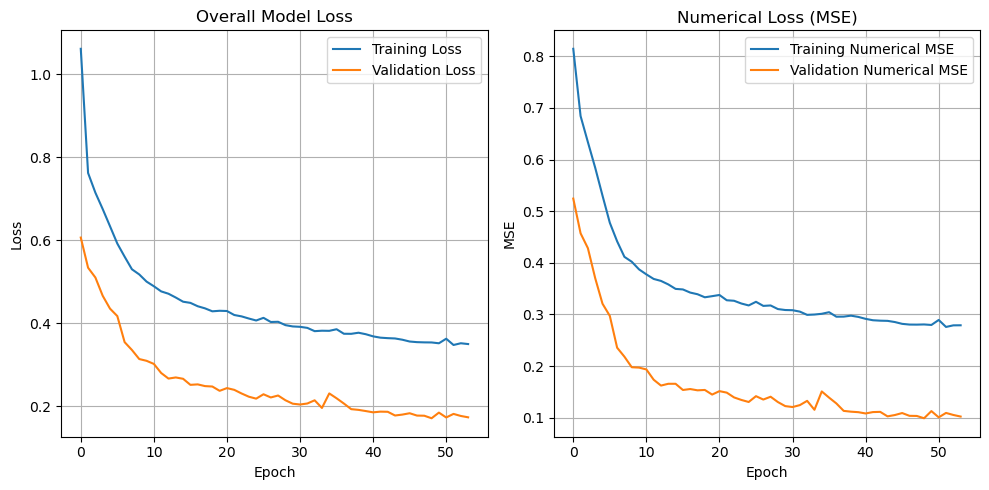

In [4]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Create a figure with multiple subplots
    plt.figure(figsize=(10, 5))

    # Plot 1: Overall Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Overall Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot 2: Numerical Loss (MSE)
    if 'mse' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mse'], label='Training Numerical MSE')
        plt.plot(history.history['val_mse'], label='Validation Numerical MSE')
        plt.title('Numerical Loss (MSE)')
        plt.xlabel('Epoch')
        plt.ylabel('MSE')
        plt.legend()
        plt.grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Call the function with your training history
plot_training_history(history)
